In [42]:
import time
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
import torch.optim as optim
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from itertools import combinations

**`Step 1: Data Processing`**

In [43]:
# Load the dataset (replace with your dataset path)
data = pd.read_csv('Almond.csv')

In [44]:
# Inspecting the dataset
data

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA


In [45]:
#The information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2803 entries, 0 to 2802
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2803 non-null   int64  
 1   Length (major axis)       1946 non-null   float64
 2   Width (minor axis)        1861 non-null   float64
 3   Thickness (depth)         1799 non-null   float64
 4   Area                      2803 non-null   float64
 5   Perimeter                 2803 non-null   float64
 6   Roundness                 1946 non-null   float64
 7   Solidity                  2803 non-null   float64
 8   Compactness               2803 non-null   float64
 9   Aspect Ratio              1004 non-null   float64
 10  Eccentricity              1004 non-null   float64
 11  Extent                    2803 non-null   float64
 12  Convex hull(convex area)  2803 non-null   float64
 13  Type                      2803 non-null   object 
dtypes: float

In [46]:
#Analysis of the missing values
data["Positioning"] = 0

for row in data.iterrows():
    if pd.isna(row[1]["Width (minor axis)"]):
        data.at[row[0], "Positioning"] = 1
    elif pd.isna(row[1]["Thickness (depth)"]):
        data.at[row[0], "Positioning"] = 2

#Missing data information
def display(dfs, names):
    dis = pd.DataFrame(dfs[0].dtypes, columns=['dtypes'])
    for i, df in enumerate(dfs):
        dis[f"{names[i]}_missing#"] = dfs[i].isna().sum()
        dis[f"{names[i]}_missing%"] = (dfs[i].isna().sum()) / len(dfs[i])
        dis[f"{names[i]}_uniques"] = dfs[i].nunique().values
    return dis

# Call the report function
dfs = [data]
names = ["Almond DF"]
display = display(dfs, names)
display.style.background_gradient(cmap="viridis")

,dtypes,Almond DF_missing#,Almond DF_missing%,Almond DF_uniques
Unnamed: 0,int64,0,0.000000,2803
Length (major axis),float64,857,0.305744,1944
Width (minor axis),float64,942,0.336068,1859
Thickness (depth),float64,1004,0.358188,1797
Area,float64,0,0.000000,2750
Perimeter,float64,0,0.000000,2793
Roundness,float64,857,0.305744,1944
Solidity,float64,0,0.000000,2800
Compactness,float64,0,0.000000,2800
Aspect Ratio,float64,1799,0.641812,1003


In [47]:
# Separate numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns

In [48]:
# Handling missing values (simple mean imputation for numeric columns)
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Extract the almond names (e.g., Mamra, Sanora, Regular)
almond_names = data[non_numeric_cols[-1]].unique()

In [49]:
# One-hot encode the target labels (almond types: Mamra, Sanora, Regular)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(data[non_numeric_cols[-1]].values.reshape(-1, 1))

# Separate features and labels
X = data[numeric_cols].values

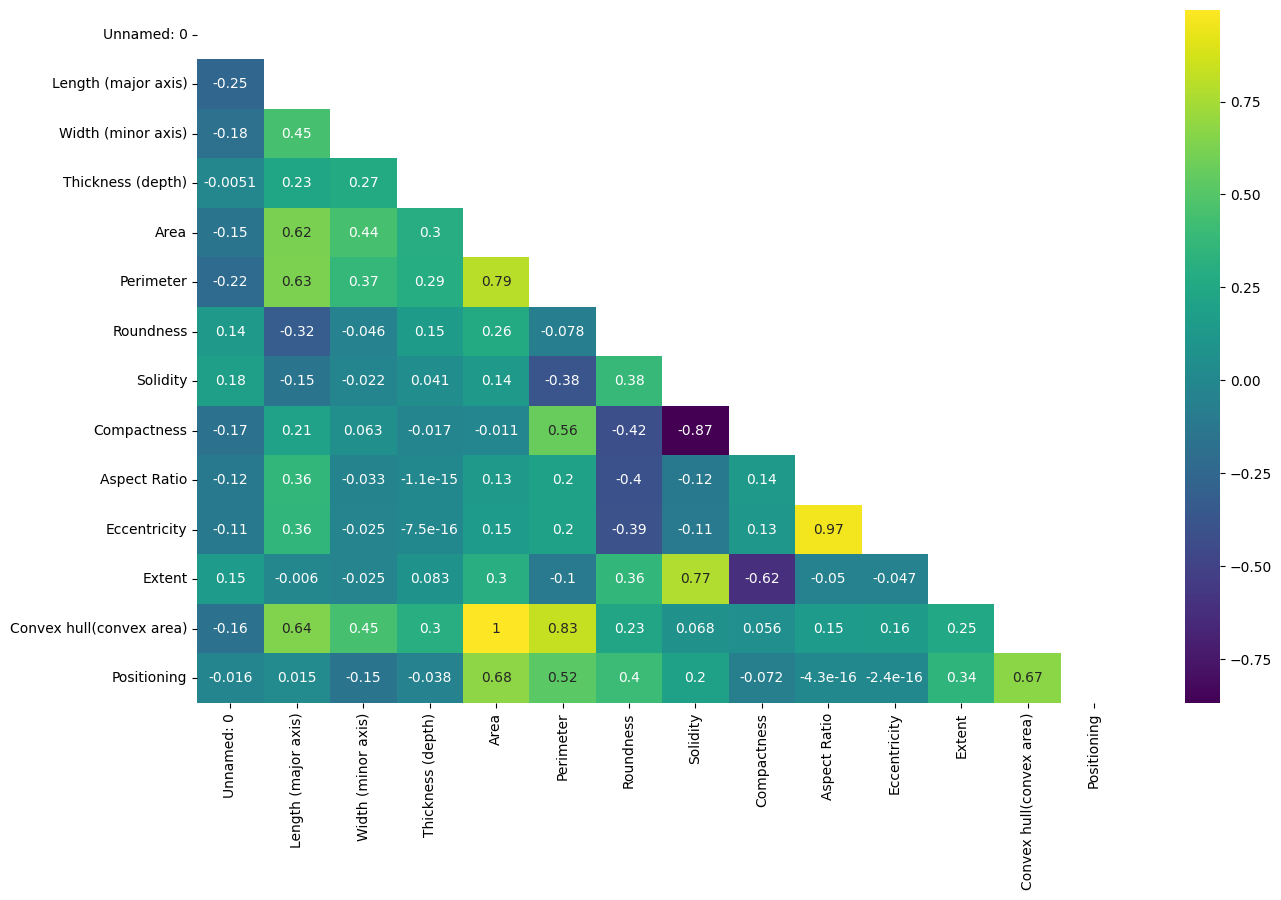

In [50]:
# Ensure only numeric columns are selected for correlation
numeric_columns = data.select_dtypes(include=[np.number])

# Plot correlation heatmap to analyse if there is any correlation between features
corr = numeric_columns.corr()  # Only compute correlation for numeric columns
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(15, 9))
sns.heatmap(corr, annot=True, cmap="viridis", mask=mask)
plt.show()

In [51]:
# Split the data into 70% training, 15% validation, and 15% test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Split the remaining 30% into 15% validation and 15% test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
# Normalize the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [52]:
# Print dataset shapes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: torch.Size([1962, 14]), Validation set: torch.Size([420, 14]), Test set: torch.Size([421, 14])


**`Step 2: Defining the Neural Network`**

In [53]:
class AlmondNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(AlmondNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn  # Pass the activation function as a parameter
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


**`Step 3: Comparative Study Between RProp and Adam`**

In [54]:
def train_model(model, optimizer, loss_fn, X_train, y_train, X_val, y_val, batch_size, epochs):
    model.train()
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Store accuracy and loss for each epoch
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Loop over epochs
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            _, predicted_train = torch.max(outputs, 1)
            _, true_labels_train = torch.max(batch_y, 1)
            correct += (predicted_train == true_labels_train).sum().item()
            total += batch_y.size(0)

        train_accuracy = correct / total
        train_losses.append(epoch_loss / len(dataloader))
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val).item()
            _, predicted_val = torch.max(val_outputs, 1)
            _, true_labels_val = torch.max(y_val, 1)
            val_accuracy = (predicted_val == true_labels_val).float().mean().item()

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Display progress for each epoch
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{len(dataloader)}/{len(dataloader)} ━━━━━━━━━━━━━━━━━━━━ "
              f"{time.time() - start_time:.2f}s {batch_size}ms/step "
              f"- accuracy: {train_accuracy:.4f} - loss: {epoch_loss/len(dataloader):.4f} "
              f"- val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

    return train_accuracies, val_accuracies, train_losses, val_losses


In [55]:
# Define the model and loss function
model_rprop = AlmondNN(input_size=X_train.shape[1], hidden_size=64, output_size=y_train.shape[1], activation_fn=nn.Softmax())
model_adam = AlmondNN(input_size=X_train.shape[1], hidden_size=64, output_size=y_train.shape[1], activation_fn=nn.Softmax())

# Define the optimizer and loss function
optimizer_rprop = torch.optim.Rprop(model_rprop.parameters())
optimizer_adam = torch.optim.Adam(model_adam.parameters(),lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [56]:
# Train with RProp
train_accuracies_rprop, val_accuracies_rprop, train_losses_rprop, val_losses_rprop = train_model(
    model_rprop, optimizer_rprop, loss_fn, X_train, y_train, X_val, y_val, batch_size=16, epochs=200
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.95s 16ms/step - accuracy: 0.6651 - loss: 0.8908 - val_accuracy: 0.7643 - val_loss: 0.7806
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.61s 16ms/step - accuracy: 0.7712 - loss: 0.7780 - val_accuracy: 0.7810 - val_loss: 0.7633
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.55s 16ms/step - accuracy: 0.7778 - loss: 0.7719 - val_accuracy: 0.7905 - val_loss: 0.7597
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.65s 16ms/step - accuracy: 0.7783 - loss: 0.7702 - val_accuracy: 0.7905 - val_loss: 0.7591
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.59s 16ms/step - accuracy: 0.7793 - loss: 0.7703 - val_accuracy: 0.7905 - val_loss: 0.7588
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.61s 16ms/step - accuracy: 0.7798 - loss: 0.7699 - val_accuracy: 0.7905 - val_loss: 0.7586
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.44s 16ms/step - accuracy: 0.7798 - loss: 0.7704 - val_accuracy: 0.7905 - val_loss: 0.7583
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.81s 16ms/step - accuracy: 

In [57]:
# Train with Adam
train_accuracies_adam, val_accuracies_adam, train_losses_adam, val_losses_adam = train_model(
    model_adam, optimizer_adam, loss_fn, X_train, y_train, X_val, y_val, batch_size=16, epochs=200
)

Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.19s 16ms/step - accuracy: 0.3899 - loss: 1.0947 - val_accuracy: 0.4714 - val_loss: 1.0897
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.18s 16ms/step - accuracy: 0.5000 - loss: 1.0824 - val_accuracy: 0.5333 - val_loss: 1.0733
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.22s 16ms/step - accuracy: 0.6335 - loss: 1.0619 - val_accuracy: 0.7119 - val_loss: 1.0493
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.19s 16ms/step - accuracy: 0.7085 - loss: 1.0347 - val_accuracy: 0.7190 - val_loss: 1.0185
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.19s 16ms/step - accuracy: 0.7283 - loss: 1.0025 - val_accuracy: 0.7262 - val_loss: 0.9847
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.16s 16ms/step - accuracy: 0.7406 - loss: 0.9700 - val_accuracy: 0.7381 - val_loss: 0.9518
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.19s 16ms/step - accuracy: 0.7574 - loss: 0.9399 - val_accuracy: 0.7548 - val_loss: 0.9238
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.17s 16ms/step - accuracy: 

*Plot Comparative Results*

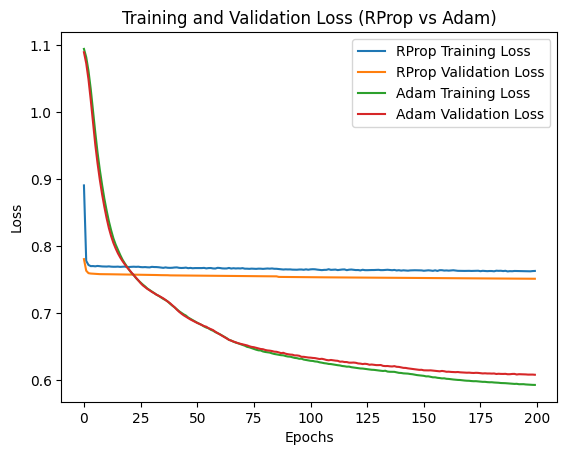

In [58]:
# Plot loss
plt.plot(train_losses_rprop, label='RProp Training Loss')
plt.plot(val_losses_rprop, label='RProp Validation Loss')
plt.plot(train_losses_adam, label='Adam Training Loss')
plt.plot(val_losses_adam, label='Adam Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (RProp vs Adam)')
plt.legend()
plt.show()

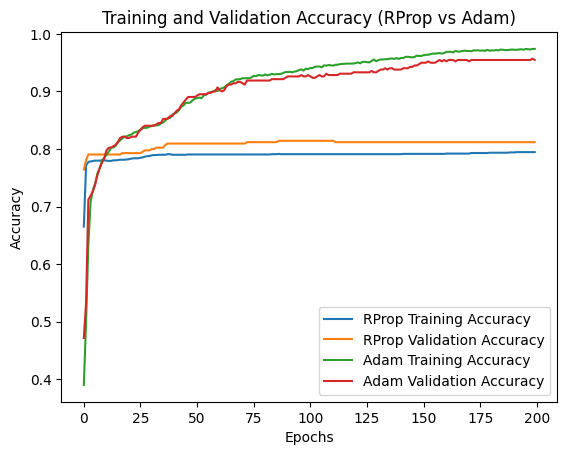

In [59]:
# Plot accuracy
plt.plot(train_accuracies_rprop, label='RProp Training Accuracy')
plt.plot(val_accuracies_rprop, label='RProp Validation Accuracy')
plt.plot(train_accuracies_adam, label='Adam Training Accuracy')
plt.plot(val_accuracies_adam, label='Adam Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (RProp vs Adam)')
plt.legend()
plt.show()

*Statistical Analysis*

In [60]:
# Perform t-test on validation accuracy
t_stat, p_value = ttest_ind(val_accuracies_rprop, val_accuracies_adam)

if p_value < 0.05:
    print(f"There is a significant difference between RProp and Adam: t-stat={t_stat}, p-value={p_value}")
else:
    print(f"There is no significant difference: t-stat={t_stat}, p-value={p_value}")

There is a significant difference between RProp and Adam: t-stat=-20.11286918094315, p-value=1.376023357475277e-62


**`Step 4: Hyperparameter Optimization and Grid Search`**

Grid Search with K-Fold Cross-Validation: **Batch Sizes** Vs **The number of Epochs**

In [61]:
# Define hyperparameter grid Modified
batch_sizes = [16, 32, 64]
epochs_list = [50, 100, 200]
activation_fn = nn.Softmax(dim=1)

kfold = KFold(n_splits=5, shuffle=True)

# Store results (now storing fold-wise accuracies)
results = []

for batch_size, epochs in product(batch_sizes, epochs_list):
    fold_train_accuracies = []
    fold_val_accuracies = []

    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Define the model, optimizer, and loss function
        model = AlmondNN(X_train.shape[1], 64, y_train.shape[1], activation_fn)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        # Train the model and get training/validation accuracies
        train_accuracies, val_accuracies, _, _ = train_model(
            model, optimizer, loss_fn, X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size=batch_size, epochs=epochs
        )

        # Store the final accuracies for the fold
        fold_train_accuracies.append(train_accuracies[-1])  # Last training accuracy for this fold
        fold_val_accuracies.append(val_accuracies[-1])      # Last validation accuracy for this fold

    # Store fold-wise results (do not average them here)
    results.append((batch_size, epochs, fold_train_accuracies, fold_val_accuracies))

Streaming output truncated to the last 5000 lines.
Epoch 51/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0.09s 32ms/step - accuracy: 0.8311 - loss: 0.7510 - val_accuracy: 0.8066 - val_loss: 0.7749
Epoch 52/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0.08s 32ms/step - accuracy: 0.8324 - loss: 0.7492 - val_accuracy: 0.8092 - val_loss: 0.7735
Epoch 53/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0.08s 32ms/step - accuracy: 0.8324 - loss: 0.7499 - val_accuracy: 0.8117 - val_loss: 0.7721
Epoch 54/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0.08s 32ms/step - accuracy: 0.8343 - loss: 0.7478 - val_accuracy: 0.8142 - val_loss: 0.7706
Epoch 55/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0.08s 32ms/step - accuracy: 0.8343 - loss: 0.7447 - val_accuracy: 0.8117 - val_loss: 0.7694
Epoch 56/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0.08s 32ms/step - accuracy: 0.8362 - loss: 0.7438 - val_accuracy: 0.8142 - val_loss: 0.7683
Epoch 57/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0.08s 32ms/step - accuracy: 0.8349 - loss: 0.7420 - val_accuracy: 0.8117 - val_loss: 0.7671
Epoch 58/200
50/50 ━━━━━━

*Statistical Analysis with Hypothesis Testing*

In [62]:
# Extract all unique configurations (batch_size, epochs)
configurations = [(batch_size, epochs) for batch_size, epochs, train_accs, val_accs in results]

# Perform t-tests for all pairs of configurations
for (config1, config2) in combinations(configurations, 2):
    config1_batch_size, config1_epochs = config1
    config2_batch_size, config2_epochs = config2

    # Extract fold accuracies for each configuration
    config1_val_accuracies = []
    config2_val_accuracies = []

    for batch_size, epochs, train_accs, val_accs in results:
        if batch_size == config1_batch_size and epochs == config1_epochs:
            config1_val_accuracies = val_accs  # Fold accuracies for config 1
        if batch_size == config2_batch_size and epochs == config2_epochs:
            config2_val_accuracies = val_accs  # Fold accuracies for config 2

    # Perform the t-test
    t_stat, p_value = ttest_ind(config1_val_accuracies, config2_val_accuracies)

    # Display the results of the t-test for this pair of configurations
    print(f"Comparing Config 1: Batch Size={config1_batch_size}, Epochs={config1_epochs} "
          f"with Config 2: Batch Size={config2_batch_size}, Epochs={config2_epochs}")
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

    # Interpret the p-value
    if p_value < 0.05:
        print("The difference in validation accuracies is statistically significant.\n")
    else:
        print("The difference in validation accuracies is not statistically significant.\n")

Comparing Config 1: Batch Size=16, Epochs=50 with Config 2: Batch Size=16, Epochs=100
T-statistic: -8.675139506323108, P-value: 2.4262078373238647e-05
The difference in validation accuracies is statistically significant.

Comparing Config 1: Batch Size=16, Epochs=50 with Config 2: Batch Size=16, Epochs=200
T-statistic: -13.820687242013468, P-value: 7.257911554043385e-07
The difference in validation accuracies is statistically significant.

Comparing Config 1: Batch Size=16, Epochs=50 with Config 2: Batch Size=32, Epochs=50
T-statistic: 2.3736044689346945, P-value: 0.04499257152479323
The difference in validation accuracies is statistically significant.

Comparing Config 1: Batch Size=16, Epochs=50 with Config 2: Batch Size=32, Epochs=100
T-statistic: -0.725484880175028, P-value: 0.4888306507163245
The difference in validation accuracies is not statistically significant.

Comparing Config 1: Batch Size=16, Epochs=50 with Config 2: Batch Size=32, Epochs=200
T-statistic: -7.28707826459794

In [63]:
# Loop through the results and calculate the average, variance, and standard deviation for each configuration
for batch_size, epochs, train_accs, val_accs in results:
    avg_train_accuracy = np.mean(train_accs)  # Compute the average training accuracy
    avg_val_accuracy = np.mean(val_accs)      # Compute the average validation accuracy

    # Compute variance and standard deviation for training and validation accuracies
    train_variance = np.var(train_accs)
    train_std_dev = np.std(train_accs)
    val_variance = np.var(val_accs)
    val_std_dev = np.std(val_accs)

    # Print the results for each configuration
    print(f"Configuration: Batch Size={batch_size}, Epochs={epochs}")
    print(f"Training Accuracy: Avg={avg_train_accuracy:.4f}, Variance={train_variance:.4f}, Std Dev={train_std_dev:.4f}")
    print(f"Validation Accuracy: Avg={avg_val_accuracy:.4f}, Variance={val_variance:.4f}, Std Dev={val_std_dev:.4f}")
    print("----------------------------------------------------")

Configuration: Batch Size=16, Epochs=50
Training Accuracy: Avg=0.8437, Variance=0.0000, Std Dev=0.0052
Validation Accuracy: Avg=0.8338, Variance=0.0001, Std Dev=0.0072
----------------------------------------------------
Configuration: Batch Size=16, Epochs=100
Training Accuracy: Avg=0.9185, Variance=0.0001, Std Dev=0.0090
Validation Accuracy: Avg=0.8925, Variance=0.0001, Std Dev=0.0115
----------------------------------------------------
Configuration: Batch Size=16, Epochs=200
Training Accuracy: Avg=0.9666, Variance=0.0001, Std Dev=0.0073
Validation Accuracy: Avg=0.9455, Variance=0.0002, Std Dev=0.0145
----------------------------------------------------
Configuration: Batch Size=32, Epochs=50
Training Accuracy: Avg=0.8266, Variance=0.0001, Std Dev=0.0090
Validation Accuracy: Avg=0.8175, Variance=0.0001, Std Dev=0.0117
----------------------------------------------------
Configuration: Batch Size=32, Epochs=100
Training Accuracy: Avg=0.8572, Variance=0.0001, Std Dev=0.0091
Validation

In [64]:
# Initialize variables to track the best configuration for validation and training accuracies
best_val_config = None
best_train_config = None
best_avg_val_accuracy = -1  # Initially set to a low value
best_avg_train_accuracy = -1  # Initially set to a low value

# Loop through the results and calculate the average validation and training accuracies for each configuration
for batch_size, epochs, train_accs, val_accs in results:
    avg_train_accuracy = np.mean(train_accs)  # Compute the average training accuracy
    avg_val_accuracy = np.mean(val_accs)      # Compute the average validation accuracy

    # Update the best validation configuration if the current one is better
    if avg_val_accuracy > best_avg_val_accuracy:
        best_avg_val_accuracy = avg_val_accuracy
        best_val_config = (batch_size, epochs)

    # Update the best training configuration if the current one is better
    if avg_train_accuracy > best_avg_train_accuracy:
        best_avg_train_accuracy = avg_train_accuracy
        best_train_config = (batch_size, epochs)

# Print out the best configurations and their corresponding accuracies
best_val_batch_size, best_val_epochs = best_val_config
best_train_batch_size, best_train_epochs = best_train_config

print(f"The best validation configuration is:")
print(f"Batch Size: {best_val_batch_size}, Epochs: {best_val_epochs}")
print(f"With an average validation accuracy of: {best_avg_val_accuracy:.4f}")

print("\nThe best training configuration is:")
print(f"Batch Size: {best_train_batch_size}, Epochs: {best_train_epochs}")
print(f"With an average training accuracy of: {best_avg_train_accuracy:.4f}")

The best validation configuration is:
Batch Size: 16, Epochs: 200
With an average validation accuracy of: 0.9455

The best training configuration is:
Batch Size: 16, Epochs: 200
With an average training accuracy of: 0.9666


 *Visualize Results Using a Heatmap*

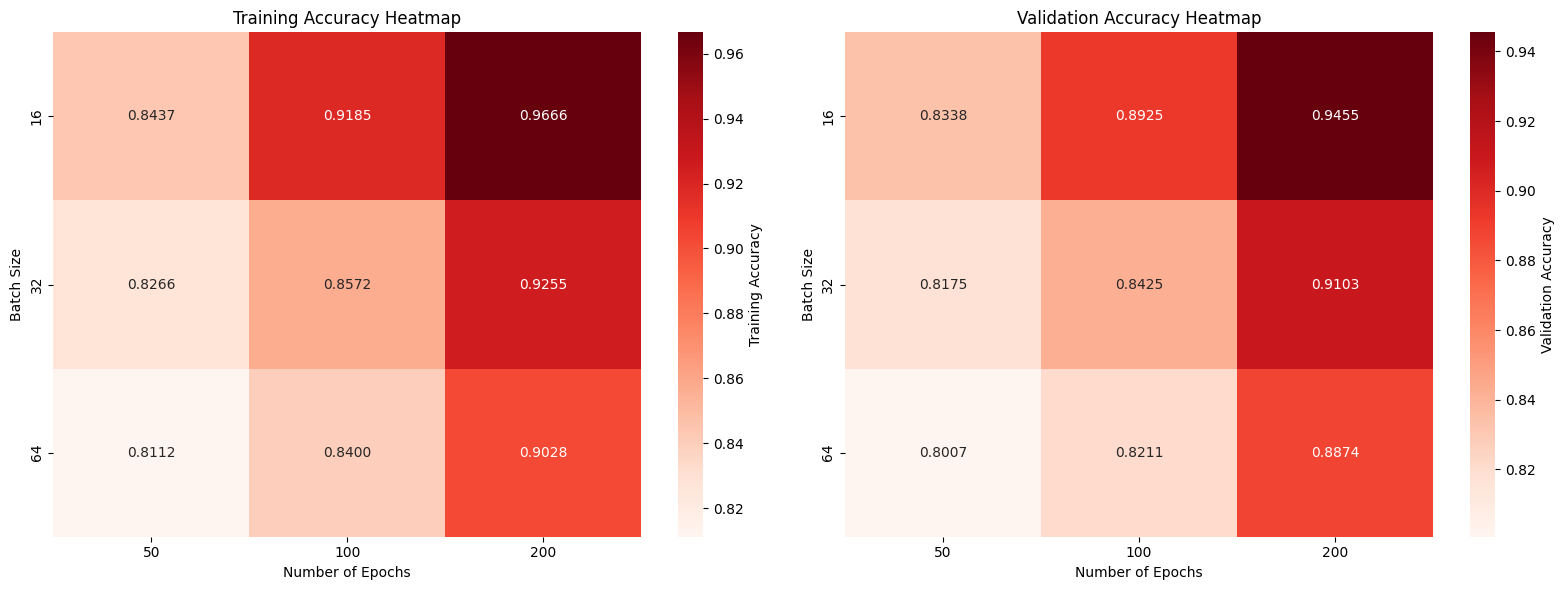

In [65]:
# Convert results to numpy array (each element in results is a tuple of batch_size, epochs, fold_train_accuracies, fold_val_accuracies)
# For heatmap, we need to average the fold accuracies for each configuration

batch_sizes = sorted(list(set([r[0] for r in results])))
epochs_list = sorted(list(set([r[1] for r in results])))

# Initialize arrays to store the averaged accuracies
train_accuracies_avg = np.zeros((len(batch_sizes), len(epochs_list)))
val_accuracies_avg = np.zeros((len(batch_sizes), len(epochs_list)))

# Fill in the average accuracies for each batch size and epoch combination
for batch_size, epochs, fold_train_accuracies, fold_val_accuracies in results:
    avg_train_accuracy = np.mean(fold_train_accuracies)
    avg_val_accuracy = np.mean(fold_val_accuracies)

    # Find the indices in the grid
    batch_idx = batch_sizes.index(batch_size)
    epochs_idx = epochs_list.index(epochs)

    # Store the averages in the corresponding grid location
    train_accuracies_avg[batch_idx, epochs_idx] = avg_train_accuracy
    val_accuracies_avg[batch_idx, epochs_idx] = avg_val_accuracy

# Create heatmaps to compare training and validation accuracy
plt.figure(figsize=(16, 6))

# Plot heatmap for Training Accuracy
plt.subplot(1, 2, 1)
sns.heatmap(train_accuracies_avg, annot=True, fmt=".4f", cmap="Reds", xticklabels=epochs_list, yticklabels=batch_sizes,
            cbar_kws={'label': 'Training Accuracy'})
plt.title("Training Accuracy Heatmap")
plt.xlabel("Number of Epochs")
plt.ylabel("Batch Size")

# Plot heatmap for Validation Accuracy
plt.subplot(1, 2, 2)
sns.heatmap(val_accuracies_avg, annot=True, fmt=".4f", cmap="Reds", xticklabels=epochs_list, yticklabels=batch_sizes,
            cbar_kws={'label': 'Validation Accuracy'})
plt.title("Validation Accuracy Heatmap")
plt.xlabel("Number of Epochs")
plt.ylabel("Batch Size")

# Show both heatmaps
plt.tight_layout()
plt.show()

*`GRID SEARCH {ACTIVATION FUNCTIONS VS HIDDEN LAYERS}`*

The Neural Network with Variables **Hidden Layers** and **Activation Function**

In [66]:
class AlmondNNVariableLayers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, activation_fn):
        super(AlmondNNVariableLayers, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))

        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

        # Activation function passed as a parameter
        self.activation_fn = activation_fn
        self.softmax = nn.Softmax(dim=1)  # Softmax for the output

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        x = self.output_layer(x)
        return self.softmax(x)

*The Training Loop*

In [67]:
def train_model_rprop(model, X_train, y_train, X_val, y_val, batch_size, epochs):
    optimizer = torch.optim.Rprop(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Store accuracy and loss for each epoch
    train_accuracies = []
    val_accuracies = []

    # Loop over epochs
    for epoch in range(epochs):
        epoch_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time.time()  # Start time to track the time for each epoch

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Calculate training accuracy for this batch
            _, predicted_train = torch.max(outputs, 1)
            _, true_labels_train = torch.max(batch_y, 1)
            correct_train += (predicted_train == true_labels_train).sum().item()
            total_train += batch_y.size(0)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation accuracy
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            _, predicted_val = torch.max(val_outputs, 1)
            _, true_labels_val = torch.max(y_val, 1)
            val_accuracy = (predicted_val == true_labels_val).float().mean().item()

        val_accuracies.append(val_accuracy)

        # Display progress for each epoch
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{len(dataloader)}/{len(dataloader)} ━━━━━━━━━━━━━━━━━━━━ "
              f"{time.time() - start_time:.2f}s {batch_size}ms/step "
              f"- accuracy: {train_accuracy:.4f} - val_accuracy: {val_accuracy:.4f}")

    return train_accuracies, val_accuracies

*Grid Search*

In [68]:
# Hyperparameters for grid search
activation_functions = {
    'Sigmoid': nn.Sigmoid(),
    'Softmax': nn.Softmax(dim=1),
    'ReLU': nn.ReLU()
}

hidden_layers_list = [16,32,64]  # Number of hidden layers
batch_size = 16
epochs = 50
kfold = KFold(n_splits=5, shuffle=True)

# Store results (now storing fold-wise accuracies)
results = []

# Loop through each activation function and number of hidden layers
for activation_name, activation_fn in activation_functions.items():
    for num_hidden_layers in hidden_layers_list:
        fold_train_accuracies = []
        fold_val_accuracies = []

        # Perform K-Fold Cross Validation
        for train_idx, val_idx in kfold.split(X_train):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Define the model with the current hyperparameters
            model = AlmondNNVariableLayers(
                input_size=X_train.shape[1],
                hidden_size=32,
                output_size=y_train.shape[1],
                num_hidden_layers=num_hidden_layers,
                activation_fn=activation_fn
            )

            # Train the model and get accuracies
            train_accuracies, val_accuracies = train_model_rprop(
                model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size=batch_size, epochs=epochs
            )

            # Store the final accuracies for this fold
            fold_train_accuracies.append(train_accuracies[-1])  # Last training accuracy for this fold
            fold_val_accuracies.append(val_accuracies[-1])      # Last validation accuracy for this fold

        # Store fold-wise results (do not average them here)
        results.append((activation_name, num_hidden_layers, fold_train_accuracies, fold_val_accuracies))

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.65s 16ms/step - accuracy: 0.3244 - val_accuracy: 0.3333
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.68s 16ms/step - accuracy: 0.3301 - val_accuracy: 0.3333
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.69s 16ms/step - accuracy: 0.3301 - val_accuracy: 0.3333
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.68s 16ms/step - accuracy: 0.3301 - val_accuracy: 0.3333
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.70s 16ms/step - accuracy: 0.3301 - val_accuracy: 0.3333
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.70s 16ms/step - accuracy: 0.3301 - val_accuracy: 0.3333
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.69s 16ms/step - accuracy: 0.5271 - val_accuracy: 0.4936
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.73s 16ms/step - accuracy: 0.5073 - val_accuracy: 0.5649
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.69s 16ms/step - accuracy: 0.5570 - val_accuracy: 0.5623
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0.72s 16ms/step - accuracy: 0.5481 - val_accuracy: 0.5623
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 

*Heatmaps for Training and Validation Accuracy*

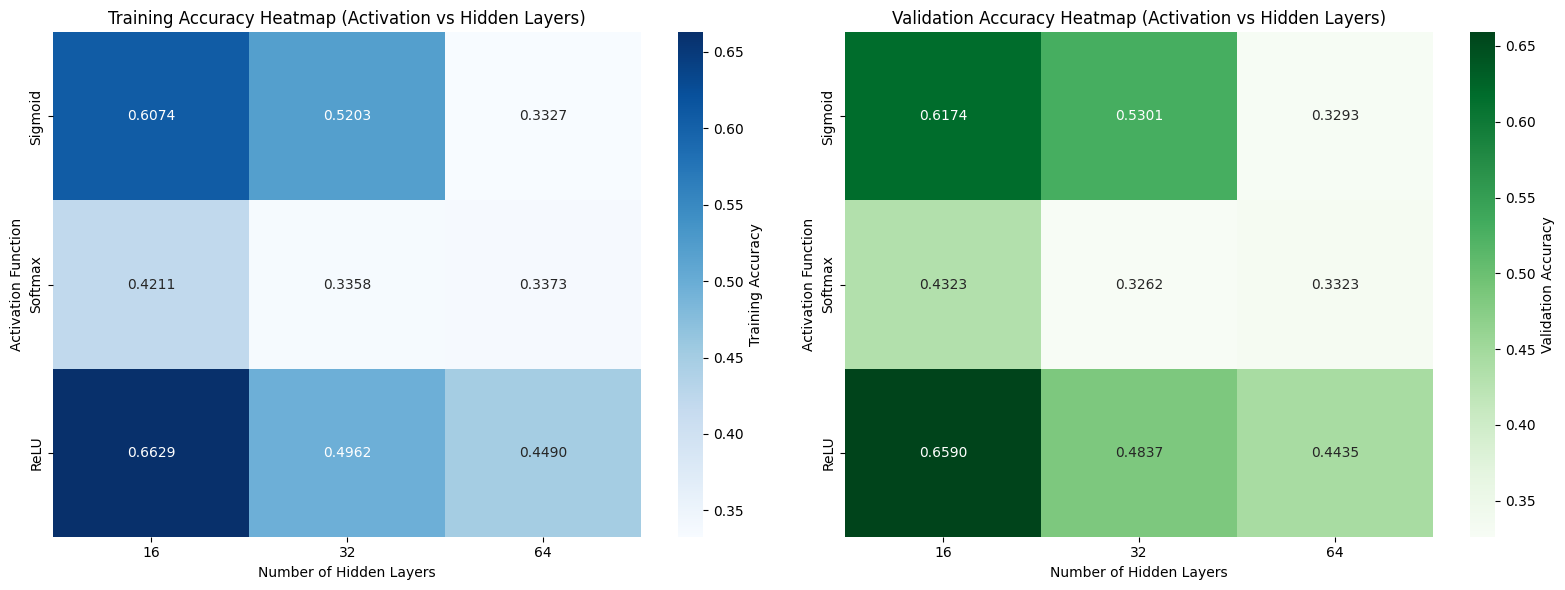

In [69]:
# Extract unique activation functions and hidden layers
activation_names = list(activation_functions.keys())
hidden_layers_list = sorted(hidden_layers_list)

# Initialize arrays to store average accuracies across folds for heatmaps
train_accuracies_avg = np.zeros((len(activation_names), len(hidden_layers_list)))
val_accuracies_avg = np.zeros((len(activation_names), len(hidden_layers_list)))

# Fill the arrays with average accuracy data from all folds
for activation_name, num_hidden_layers, fold_train_accuracies, fold_val_accuracies in results:
    activation_idx = activation_names.index(activation_name)
    layer_idx = hidden_layers_list.index(num_hidden_layers)

    # Compute the average accuracy across all folds for the given configuration
    avg_train_accuracy = np.mean(fold_train_accuracies)
    avg_val_accuracy = np.mean(fold_val_accuracies)

    # Store the average accuracies in the corresponding grid location
    train_accuracies_avg[activation_idx, layer_idx] = avg_train_accuracy
    val_accuracies_avg[activation_idx, layer_idx] = avg_val_accuracy

# Plot the heatmaps
plt.figure(figsize=(16, 6))

# Training accuracy heatmap
plt.subplot(1, 2, 1)
sns.heatmap(train_accuracies_avg, annot=True, fmt=".4f", cmap="Blues", xticklabels=hidden_layers_list, yticklabels=activation_names,
            cbar_kws={'label': 'Training Accuracy'})
plt.title("Training Accuracy Heatmap (Activation vs Hidden Layers)")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Activation Function")

# Validation accuracy heatmap
plt.subplot(1, 2, 2)
sns.heatmap(val_accuracies_avg, annot=True, fmt=".4f", cmap="Greens", xticklabels=hidden_layers_list, yticklabels=activation_names,
            cbar_kws={'label': 'Validation Accuracy'})
plt.title("Validation Accuracy Heatmap (Activation vs Hidden Layers)")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Activation Function")

plt.tight_layout()
plt.show()

*Statistical Analysis for Each Configuration*

In [70]:
# Perform t-tests comparing validation accuracies across activations for each hidden layer configuration
from itertools import combinations
from scipy.stats import ttest_ind

# Loop over each hidden layer count
for num_hidden_layers in hidden_layers_list:
    # Collect all validation accuracies for the given hidden layer configuration across folds
    val_accuracies_by_activation = {
        activation_name: [] for activation_name in activation_names
    }

    # Fill validation accuracies for current hidden layer count
    for activation_name, hidden_layers, fold_train_accuracies, fold_val_accuracies in results:
        if hidden_layers == num_hidden_layers:
            val_accuracies_by_activation[activation_name].extend(fold_val_accuracies)  # Include all fold accuracies

    # Perform pairwise t-tests between each activation function
    for (activation1, activation2) in combinations(activation_names, 2):
        acc1 = val_accuracies_by_activation[activation1]
        acc2 = val_accuracies_by_activation[activation2]

        # Perform t-test across fold validation accuracies
        t_stat, p_value = ttest_ind(acc1, acc2)

        # Print results
        print(f"T-test between {activation1} and {activation2} for {num_hidden_layers} hidden layers:")
        print(f"T-statistic: {t_stat}, P-value: {p_value}")
        if p_value < 0.05:
            print("The difference is statistically significant.\n")
        else:
            print("No statistically significant difference.\n")

T-test between Sigmoid and Softmax for 16 hidden layers:
T-statistic: 1.9548481218076679, P-value: 0.08634290102379356
No statistically significant difference.

T-test between Sigmoid and ReLU for 16 hidden layers:
T-statistic: -0.527669203150477, P-value: 0.6120462701683251
No statistically significant difference.

T-test between Softmax and ReLU for 16 hidden layers:
T-statistic: -4.028136567556765, P-value: 0.0037978918877500305
The difference is statistically significant.

T-test between Sigmoid and Softmax for 32 hidden layers:
T-statistic: 9.645762872307511, P-value: 1.1103804138705966e-05
The difference is statistically significant.

T-test between Sigmoid and ReLU for 32 hidden layers:
T-statistic: 0.7853841130661189, P-value: 0.4548570193746496
No statistically significant difference.

T-test between Softmax and ReLU for 32 hidden layers:
T-statistic: -2.7693653731101984, P-value: 0.024320500328870058
The difference is statistically significant.

T-test between Sigmoid and Sof

In [72]:
# Initialize variables to track the best configuration for validation and training accuracies
best_val_config = None
best_train_config = None
best_avg_val_accuracy = -1  # Initially set to a low value
best_avg_train_accuracy = -1  # Initially set to a low value

# Loop through the results and calculate the average validation and training accuracies for each configuration
for activation_name, num_hidden_layers, train_accs, val_accs in results:
    avg_train_accuracy = np.mean(train_accs)  # Compute the average training accuracy across folds
    avg_val_accuracy = np.mean(val_accs)      # Compute the average validation accuracy across folds

    # Update the best validation configuration if the current one is better
    if avg_val_accuracy > best_avg_val_accuracy:
        best_avg_val_accuracy = avg_val_accuracy
        best_val_config = (activation_name, num_hidden_layers)

    # Update the best training configuration if the current one is better
    if avg_train_accuracy > best_avg_train_accuracy:
        best_avg_train_accuracy = avg_train_accuracy
        best_train_config = (activation_name, num_hidden_layers)

# Print out the best configurations and their corresponding accuracies
best_val_activation, best_val_hidden_layers = best_val_config
best_train_activation, best_train_hidden_layers = best_train_config

print(f"The best validation configuration is:")
print(f"Activation Function: {best_val_activation}, Number of Hidden Layers: {best_val_hidden_layers}")
print(f"With an average validation accuracy of: {best_avg_val_accuracy:.4f}")

print("\nThe best training configuration is:")
print(f"Activation Function: {best_train_activation}, Number of Hidden Layers: {best_train_hidden_layers}")
print(f"With an average training accuracy of: {best_avg_train_accuracy:.4f}")

The best validation configuration is:
Activation Function: ReLU, Number of Hidden Layers: 16
With an average validation accuracy of: 0.6590

The best training configuration is:
Activation Function: ReLU, Number of Hidden Layers: 16
With an average training accuracy of: 0.6629


**`Step 5: Hybrid Training`**

*Hybrid Optimizer Function*

In [73]:
def hybrid_optimizer_step(model, optimizer_rprop, optimizer_adam):
    for param in model.parameters():
        # Gradients for each optimizer
        grad_rprop = param.grad.clone()  # Gradients from RProp
        grad_adam = param.grad.clone()  # Gradients from Adam

        # Average the gradients
        avg_grad = (grad_rprop + grad_adam) / 2

        # Apply the average gradient as the update
        param.grad = avg_grad

*Hybrid Training Loop*

In [74]:
def train_hybrid_model(model, optimizer_rprop, optimizer_adam, loss_fn, X_train, y_train, X_val, y_val, batch_size, epochs):
    model.train()
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Store accuracy and loss for each epoch
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        for batch_X, batch_y in dataloader:
            optimizer_rprop.zero_grad()
            optimizer_adam.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, torch.max(batch_y, 1)[1])
            loss.backward()

            # Apply hybrid optimizer step
            hybrid_optimizer_step(model, optimizer_rprop, optimizer_adam)

            optimizer_rprop.step()
            optimizer_adam.step()

            epoch_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            _, true_labels_train = torch.max(batch_y, 1)
            correct += (predicted_train == true_labels_train).sum().item()
            total += batch_y.size(0)

        train_accuracy = correct / total
        train_losses.append(epoch_loss / len(dataloader))
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val).item()
            _, predicted_val = torch.max(val_outputs, 1)
            _, true_labels_val = torch.max(y_val, 1)
            val_accuracy = (predicted_val == true_labels_val).float().mean().item()

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Display progress for each epoch
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{len(dataloader)}/{len(dataloader)} ━━━━━━━━━━━━━━━━━━━━ "
              f"{time.time() - start_time:.2f}s {batch_size}ms/step "
              f"- accuracy: {train_accuracy:.4f} - loss: {epoch_loss/len(dataloader):.4f} "
              f"- val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

    return train_accuracies, val_accuracies, train_losses, val_losses

*Train with Hybrid Optimizer*

In [75]:
# Initialize the model and optimizers
model_hybrid = AlmondNN(input_size=X_train.shape[1], hidden_size=64, output_size=y_train.shape[1], activation_fn=nn.Softmax())

optimizer_rprop = torch.optim.Rprop(model_hybrid.parameters(),lr=0.001)
optimizer_adam = torch.optim.Adam(model_hybrid.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [76]:
# Train using hybrid optimizers
train_accuracies_hybrid, val_accuracies_hybrid, train_losses_hybrid, val_losses_hybrid = train_hybrid_model(
    model_hybrid, optimizer_rprop, optimizer_adam, loss_fn, X_train, y_train, X_val, y_val, batch_size=16, epochs=200
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.32s 16ms/step - accuracy: 0.5428 - loss: 0.9721 - val_accuracy: 0.6429 - val_loss: 0.8583
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.29s 16ms/step - accuracy: 0.6463 - loss: 0.8394 - val_accuracy: 0.7810 - val_loss: 0.8162
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.28s 16ms/step - accuracy: 0.7691 - loss: 0.8106 - val_accuracy: 0.7667 - val_loss: 0.8037
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.29s 16ms/step - accuracy: 0.7671 - loss: 0.8006 - val_accuracy: 0.7714 - val_loss: 0.7961
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.30s 16ms/step - accuracy: 0.7701 - loss: 0.7939 - val_accuracy: 0.7690 - val_loss: 0.7900
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.29s 16ms/step - accuracy: 0.7676 - loss: 0.7892 - val_accuracy: 0.7667 - val_loss: 0.7870
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.29s 16ms/step - accuracy: 0.7691 - loss: 0.7863 - val_accuracy: 0.7667 - val_loss: 0.7849
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0.28s 16ms/step - accuracy: 

*Hybrid Training Results Graph*

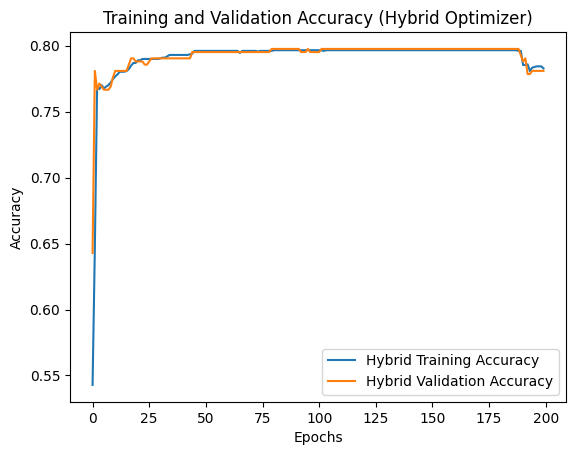

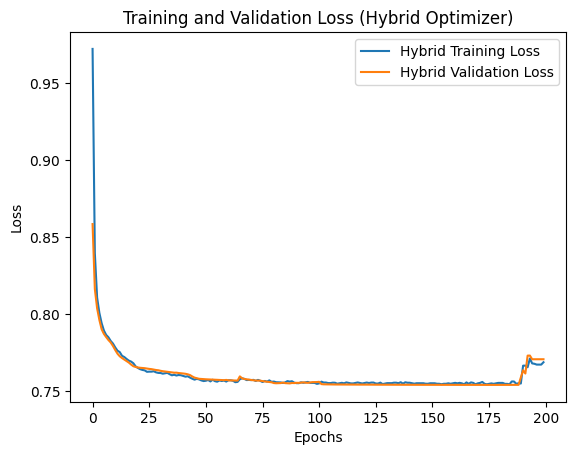

In [77]:
# Plot accuracy for Hybrid Optimizer
plt.plot(train_accuracies_hybrid, label='Hybrid Training Accuracy')
plt.plot(val_accuracies_hybrid, label='Hybrid Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Hybrid Optimizer)')
plt.legend()
plt.show()

# Plot loss for Hybrid Optimizer
plt.plot(train_losses_hybrid, label='Hybrid Training Loss')
plt.plot(val_losses_hybrid, label='Hybrid Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Hybrid Optimizer)')
plt.legend()
plt.show()

**`Step 6: Final Test Evaluation`**

In [78]:
# Test the model using the best performing optimizer (e.g., Hybrid Optimizer)
model_hybrid.eval()
with torch.no_grad():
    test_outputs = model_hybrid(X_test)
    test_loss = loss_fn(test_outputs, torch.max(y_test, 1)[1]).item()
    _, predicted_test = torch.max(test_outputs, 1)
    _, true_labels_test = torch.max(y_test, 1)
    test_accuracy = (predicted_test == true_labels_test).float().mean().item()

print(f"Test Accuracy: {test_accuracy:.4f} - Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8029 - Test Loss: 0.7486
